# Препроцессинг
В этом ноутбуке мы будем строить pipeline препроцессинга данных на примере одного гидропоста

In [628]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

from rdm_helpers import get_meteo, helper_save, split_df_by, na_heat_map, interpolate_df, nse
import rdm_helpers

plt.style.use('ggplot')

Так как мы будем обучать отдельные модели для каждого гидропоста для удобства разделим подготовленные файлы по station_id

In [629]:
old_data_path = 'datasets/'
data_path = './data/hydro/'
df_names = ['daily', 'disch_d', 'ice']

In [630]:
# for df_name in df_names:
#     df = pd.read_pickle(old_data_path + "processed_data/"+ df_name + ".pkl")
#     for grp, df in split_df_by(df, 'station_id'):
#         df.to_csv(data_path + '0' + str(grp) + '_' + df_name + '.csv', index=False)

Рассмотрим станцию расположенную на зейском водохранилище

In [631]:
station_id = 6456#5024#5012

In [632]:
hydro_df = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')

meteo_df, _ = get_meteo(station_id, 'datasets/')

### Данные с гидропостов

In [633]:
hydro_df

,stage_avg,stage_min,stage_max,temp,water_code,station_id
date,,,,,,
1984-01-01,440.0,440.0,440.0,NaN,16.0,6456
1984-01-02,441.0,441.0,441.0,NaN,16.0,6456
1984-01-03,440.0,440.0,440.0,NaN,16.0,6456
1984-01-04,440.0,440.0,440.0,NaN,16.0,6456
1984-01-05,440.0,440.0,440.0,NaN,16.0,6456
...,...,...,...,...,...,...
2017-12-27,360.0,360.0,360.0,NaN,46.0,6456
2017-12-28,359.0,359.0,359.0,NaN,46.0,6456
2017-12-29,355.0,355.0,355.0,NaN,46.0,6456


In [634]:
hydro_df.index = pd.to_datetime(hydro_df.index)

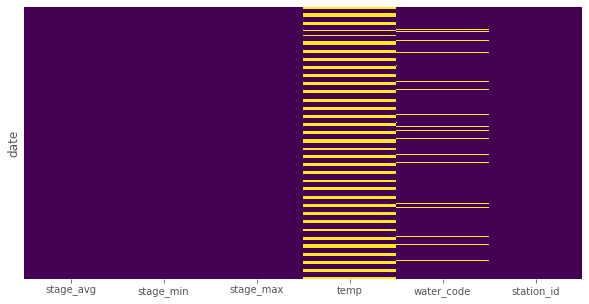

In [635]:
na_heat_map(hydro_df, figsize = (10, 5))

Интерполируем температуру воды

In [636]:
hydro_df = interpolate_df(hydro_df, cols = ['temp', 'stage_max'])

In [637]:
hydro_df['stage_delta'] = (hydro_df['stage_max'] - hydro_df['stage_min'])

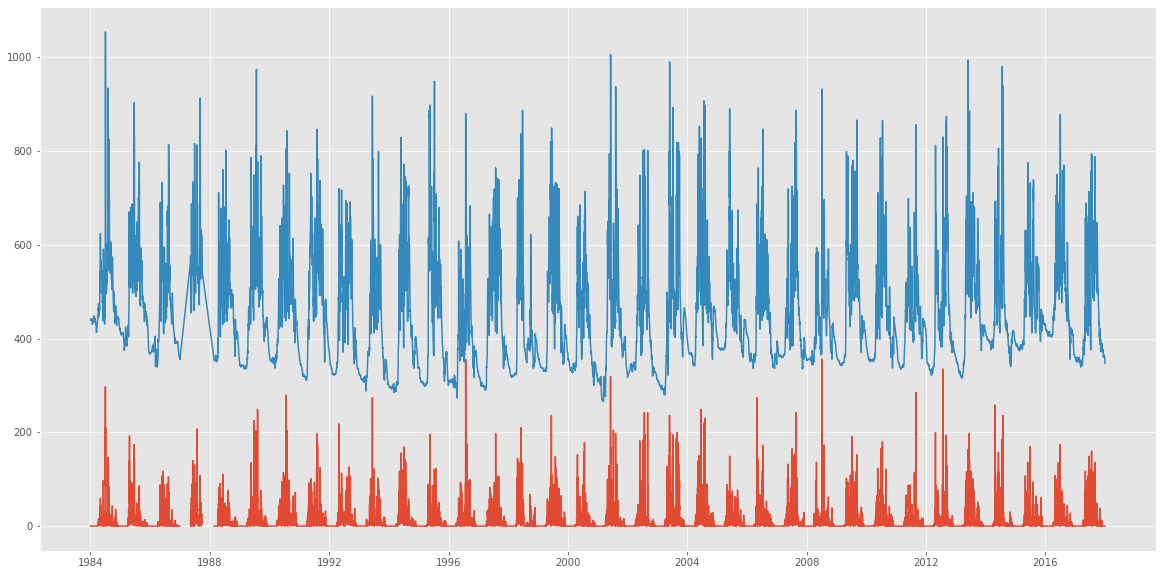

In [638]:
from rdm_helpers import plot_series
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'])

In [639]:
hydro_df[hydro_df['water_code'] == 12]

,stage_avg,stage_min,stage_max,temp,water_code,station_id,stage_delta
date,,,,,,,


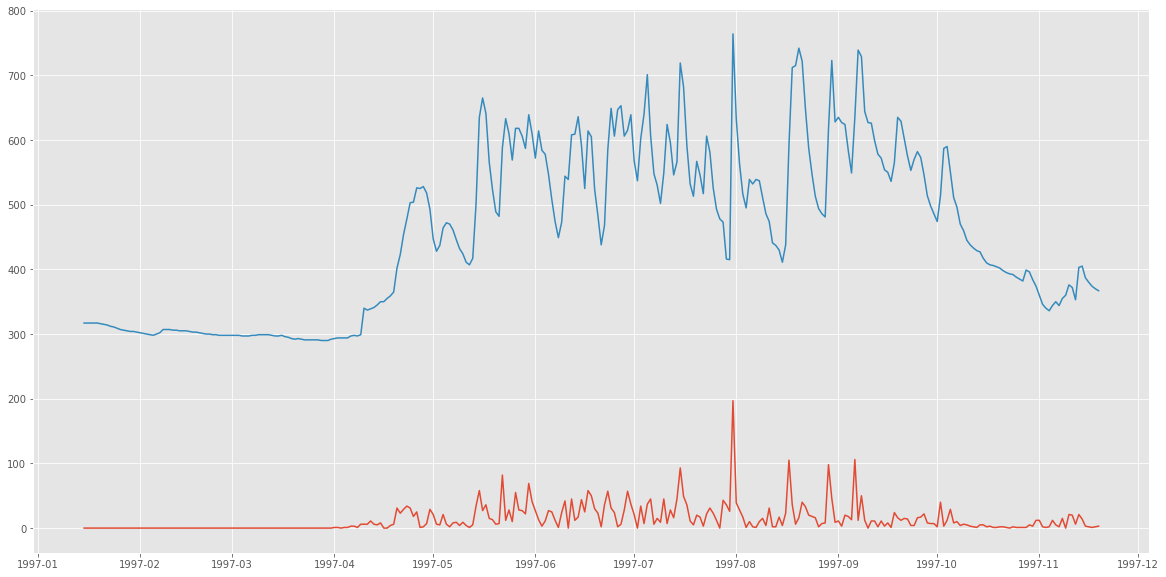

In [640]:
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'], start_date = '1997-01-15', end_date = '1997-11-19')

Очевидно, что заторы влияют на уровень воды, однако это может происходить крайне редко

In [641]:
hydro_df['congestion_up'] = hydro_df['water_code'] == 11
hydro_df['congestion_down'] = hydro_df['water_code'] == 12

In [642]:
hydro_df = hydro_df.drop(['water_code', 'station_id', 'stage_min', 'stage_avg'], axis = 1)

<AxesSubplot:xlabel='date'>

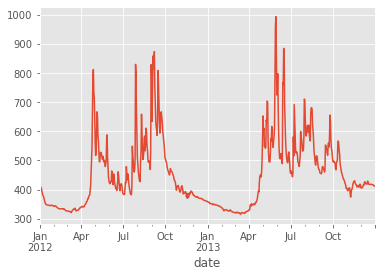

In [643]:
hydro_df['stage_max']['2012-01-01' : '2013-12-31'].plot()

In [644]:
hydro_df['doy'] = hydro_df.index.dayofyear

In [645]:
import statsmodels.api as sm

def substract_seasonality(series, period):
    return series - sm.tsa.seasonal_decompose(series, period = period).seasonal
hydro_df['seasonality'] = sm.tsa.seasonal_decompose(hydro_df['stage_max'], period = 365).seasonal
# hydro_df['seasonality']['2013-01-01':'2014-01-01'].plot()
# hydro_df['stage_max'] = substract_seasonality(hydro_df['stage_max'], 365)

In [646]:
#hydro_df[''] = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')

## Метео

In [647]:
meteo_df

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
time,,,,,,,,,,,,,,,,,,,,
2013-04-17 21:00:00,CHEGDOM,5123301,99.0,0,0,0,0,0,NaN,0.0,0,NaN,0.0,0,-7.3,0,-5.0,0,98,0
2013-04-17 18:00:00,CHEGDOM,5123301,NaN,5,0,0,0,0,NaN,0.0,0,NaN,NaN,5,-11.3,0,-5.2,0,96,0
2013-04-17 15:00:00,CHEGDOM,5123301,NaN,5,0,0,0,0,NaN,1.0,0,NaN,NaN,5,-9.5,0,-4.0,0,87,0
2013-04-17 12:00:00,CHEGDOM,5123301,NaN,5,0,0,0,0,NaN,1.0,0,NaN,NaN,5,-5.7,0,-1.9,0,78,0
2013-04-17 09:00:00,CHEGDOM,5123301,99.0,0,22,0,4,0,NaN,5.0,0,NaN,0.0,0,-1.0,0,2.4,0,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-31 21:00:00,CHEGDOM,5123301,97.0,0,130,0,1,0,NaN,2.0,0,NaN,0.0,0,4.5,0,4.7,0,92,0
2000-05-31 00:00:00,CHEGDOM,5123301,99.0,0,270,0,1,0,NaN,3.0,0,NaN,NaN,5,19.5,0,11.3,0,71,0
2000-05-31 03:00:00,CHEGDOM,5123301,99.0,0,220,0,2,0,NaN,4.0,0,NaN,NaN,5,30.6,0,17.2,0,48,0


In [648]:
meteo_df.index = pd.to_datetime(meteo_df.index)

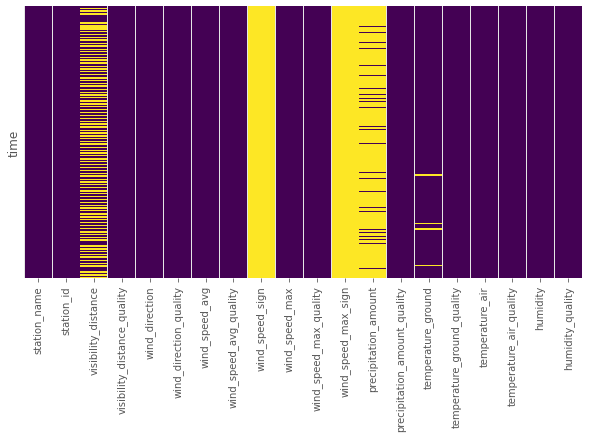

In [649]:
na_heat_map(meteo_df, figsize = (10, 5))

In [650]:
variebles = ['humidity', 'temperature_air', 'temperature_ground', 'precipitation_amount', 'wind_speed_max', 'wind_direction']
for var in variebles:
    meteo_df.loc[meteo_df[var + '_quality'] > 2, var] = np.nan

<AxesSubplot:xlabel='time'>

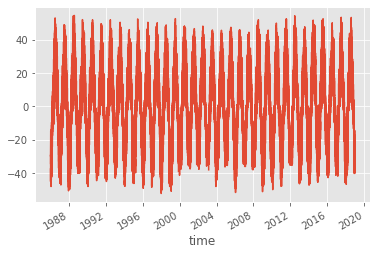

In [651]:
meteo_df['temperature_ground']['1985-01-01': '2019-01-04'].plot()

In [652]:
meteo_df['hour'] = list(map(lambda x: x.hour, meteo_df.index.time))

In [653]:
meteo_df = meteo_df.resample('D')\
.agg({
    'precipitation_amount': 'sum',
    'temperature_air': 'mean',
    'temperature_ground': 'mean',
    'humidity': 'mean'
})

In [654]:
disch_df = pd.read_csv(data_path + '0' + str(station_id) + '_disch_d.csv', engine='python')
disch_df.dropna()

,date,consumption,station_id
0,1984-01-01,21.5,6456
1,1984-01-02,21.0,6456
2,1984-01-03,20.6,6456
3,1984-01-04,20.1,6456
4,1984-01-05,19.7,6456
...,...,...,...
10385,2013-12-26,41.6,6456
10386,2013-12-27,40.8,6456
10387,2013-12-28,40.1,6456
10388,2013-12-29,39.4,6456


In [655]:
ice_df = pd.read_csv(data_path + '/0' + str(station_id) + '_ice.csv', index_col = 'date', engine='python')

ice_df.index = pd.to_datetime(ice_df.index)
ice_df.loc[~((ice_df.index.month < 4) | (ice_df.index.month > 10))]# , ['ice_thickness', 'snow_height']] = 0

# na_heat_map(ice_df['2000-04':'2000-11'])

,ice_thickness,snow_height,place,station_id
date,,,,
1984-04-05,NaN,NaN,13,6456
1984-04-05,NaN,NaN,14,6456
1984-04-10,NaN,NaN,13,6456
1984-04-10,NaN,NaN,14,6456
1984-04-15,NaN,NaN,13,6456
...,...,...,...,...
2017-04-25,NaN,NaN,14,6456
2017-04-30,NaN,NaN,13,6456
2017-04-30,NaN,NaN,14,6456


In [656]:
ice_df.index = pd.to_datetime(ice_df.index)

# ice_df = interpolate_df(ice_df, cols = ['ice_thickness', 'snow_height'])
ice_df.loc[~((ice_df.index.month < 4) | (ice_df.index.month > 10)) , ['ice_thickness', 'snow_height']] = 0

# ice_df[['snow_height_ma','ice_thickness_ma']] = ice_df[['snow_height','ice_thickness']].rolling(365).sum()

<AxesSubplot:xlabel='date'>

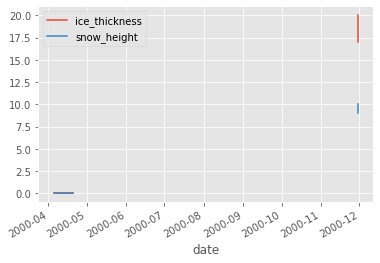

In [657]:
ice_df[['ice_thickness', 'snow_height']]['2000-04':'2000-11'].plot()

In [658]:
meteo_df['humidity'] = meteo_df['humidity'].shift(7).rolling(10).sum()
meteo_df['humidity'] = meteo_df['humidity'].shift(7).rolling(10).sum()
# hydro_df['stage_max_ma_1'] = hydro_df['stage_max'].shift(1).rolling(3).mean()
hydro_df['stage_max_ma_2'] = hydro_df['stage_max'].shift(1).rolling(2).apply(lambda x: x[1] - x[0])

In [659]:
hydro_df['stage_max_ma_2']

date
1984-01-01    NaN
1984-01-02    NaN
1984-01-03    1.0
1984-01-04   -1.0
1984-01-05    0.0
             ... 
2017-12-27    0.0
2017-12-28    0.0
2017-12-29   -1.0
2017-12-30   -4.0
2017-12-31   -5.0
Name: stage_max_ma_2, Length: 12145, dtype: float64

In [660]:
meteo_df = interpolate_df(meteo_df, cols = ['temperature_ground', 'humidity'])

In [661]:
meteo_df.index.rename('date', inplace=True)
meteo_df

,precipitation_amount,temperature_air,temperature_ground,humidity
date,,,,
1986-01-01,0.2,-33.1625,-37.2875,NaN
1986-01-02,0.2,-34.8375,-38.8875,NaN
1986-01-03,0.2,-35.4875,-40.0125,NaN
1986-01-04,0.0,-35.0250,-38.2500,NaN
1986-01-05,0.8,-30.5250,-29.6750,NaN
...,...,...,...,...
2018-12-27,0.6,-23.7125,-25.7875,7092.125
2018-12-28,0.0,-26.6500,-30.3125,6975.000
2018-12-29,0.0,-27.0875,-27.2375,6873.250


In [662]:
def extract_seasonality(series, period):
    return sm.tsa.seasonal_decompose(series, period = period).seasonal
# meteo_df['temperature_ground'] = substract_seasonality(meteo_df['temperature_ground'], 365)
# meteo_df['temperature_ground'].plot()

In [663]:
# up_stations = [6323, 6299, 6265, 6302, 6319]
# up_stations_df = []
# for i in up_stations:
#     up_stations_df.append(pd.read_csv(data_path + '/0' + str(i) + '_daily.csv', index_col = 'date', engine='python'))

# for (i, d) in enumerate(up_stations_df):
#     d.index = pd.to_datetime(d.index)

#     d = interpolate_df(d, cols = ['stage_max'])
#     hydro_df['prev_' + str(i)] = d['stage_max']

In [664]:
idf = ice_df[['snow_height_ma','ice_thickness_ma']].copy()
idf

KeyError: "None of [Index(['snow_height_ma', 'ice_thickness_ma'], dtype='object')] are in the [columns]"

In [692]:
df = pd.concat([hydro_df, meteo_df.reindex(hydro_df.index)], axis = 1)

Baseline

In [693]:
from rdm_helpers import TimeSeriesExtracter
df = TimeSeriesExtracter(['stage_delta', 'temp','precipitation_amount', 'temperature_ground', 'stage_max'],# 'humidity'], #+ ['prev_' + str(i) for i in range(4)],
                    [10,10,10,10,10],
                    [4,4,10,8,10]).fit_transform(df)

In [694]:
df = df['1987-01-01':]

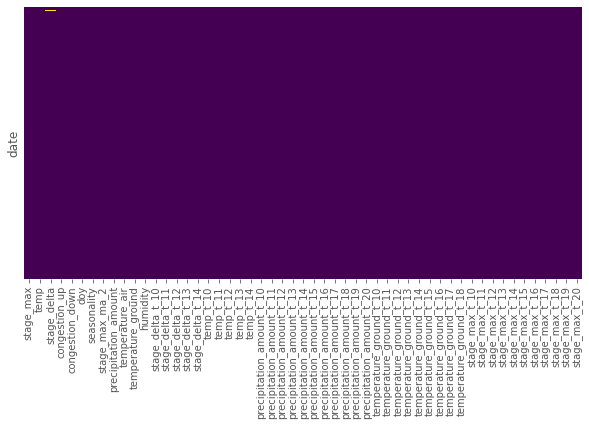

In [695]:
na_heat_map(df['1987-01-01':], figsize = (10, 5))

In [696]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11049 entries, 1987-05-01 to 2017-12-31
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stage_max                  11049 non-null  float64
 1   temp                       11049 non-null  float64
 2   stage_delta                11017 non-null  float64
 3   congestion_up              11049 non-null  bool   
 4   congestion_down            11049 non-null  bool   
 5   doy                        11049 non-null  int64  
 6   seasonality                11049 non-null  float64
 7   stage_max_ma_2             11049 non-null  float64
 8   precipitation_amount       11049 non-null  float64
 9   temperature_air            11049 non-null  float64
 10  temperature_ground         11049 non-null  float64
 11  humidity                   11049 non-null  float64
 12  stage_delta_t_10           11017 non-null  float64
 13  stage_delta_t_11           11

In [697]:
random_state = 228
label_name = 'stage_max'

In [698]:
from sklearn.model_selection import train_test_split
train_end = '2016-12-31'
test_start = '2017-01-01'
# test_end = '2017-11-11'

X = df.drop(['temp', 'stage_delta', 'precipitation_amount', 'temperature_ground', 'temperature_air', label_name], axis = 1)
Y = df[label_name]

X_train, X_test, y_train, y_test = X[:train_end], X[test_start:], Y[:train_end], Y[test_start:] #train_test_split(df.drop([label_name], axis = 1), df[label_name], train_size=0.75, random_state=random_state)

In [699]:
import lightgbm as lgb

def custom_RMSE(y_true, y_pred):
    squared_residual = 2 * (y_pred - y_true)
    grad = squared_residual
    hess = np.ones(len(y_true))
    return grad, hess

parameters = {     
#     'task': 'train',
#     'boosting_type': 'gbdt',
     'objective': 'rmse',
     'random_state': 42,
     'metric': ['l2', 'mae', 'mse'],
     'drop_rate':0.5,
     'learning_rate': 0.004,
     'feature_fraction': 0.8,
     'bagging_fraction': 0.4,
#     'bagging_freq': 10,
     "n_estimators":1000,
     "max_depth": 8,
     "num_leaves": 32,  
     "max_bin": 32,
     "n_jobs": 4,
     "random_state": random_state,
     "early_stopping_rounds":100,
    
}
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMRegressor() 

model.set_params(**parameters, metrics = ["mse", 'mae'])

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
#     random_state = random_state,
    verbose=True,
)

[1]	valid_0's l2: 12530.6	valid_0's l1: 92.119
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 12457.9	valid_0's l1: 91.8436
[3]	valid_0's l2: 12383.5	valid_0's l1: 91.5589
[4]	valid_0's l2: 12312.4	valid_0's l1: 91.289
[5]	valid_0's l2: 12239.3	valid_0's l1: 91.0051
[6]	valid_0's l2: 12167.9	valid_0's l1: 90.7272
[7]	valid_0's l2: 12098	valid_0's l1: 90.4565
[8]	valid_0's l2: 12027.7	valid_0's l1: 90.1846
[9]	valid_0's l2: 11959	valid_0's l1: 89.9161
[10]	valid_0's l2: 11890.9	valid_0's l1: 89.6423
[11]	valid_0's l2: 11821.5	valid_0's l1: 89.3686
[12]	valid_0's l2: 11752.1	valid_0's l1: 89.0929
[13]	valid_0's l2: 11683.2	valid_0's l1: 88.8171
[14]	valid_0's l2: 11616.9	valid_0's l1: 88.5562
[15]	valid_0's l2: 11565.9	valid_0's l1: 88.3332
[16]	valid_0's l2: 11500.8	valid_0's l1: 88.0742
[17]	valid_0's l2: 11435.2	valid_0's l1: 87.8093
[18]	valid_0's l2: 11370.2	valid_0's l1: 87.5468
[19]	valid_0's l2: 11305.7	valid_0's l1: 87.288
[20]	valid_0's l2: 1125

LGBMRegressor(bagging_fraction=0.4, drop_rate=0.5, early_stopping_rounds=100,
              feature_fraction=0.8, learning_rate=0.004, max_bin=32,
              max_depth=8, metric=['l2', 'mae', 'mse'], metrics=['mse', 'mae'],
              n_estimators=1000, n_jobs=4, num_leaves=32, objective='rmse',
              random_state=228)

In [700]:
from sklearn.metrics import mean_absolute_error as mae
predict = model.predict(X_test)
true = y_test.values
print(mae(true, predict))
print(nse(true, predict))

34.62443963166236
0.6342779445621203


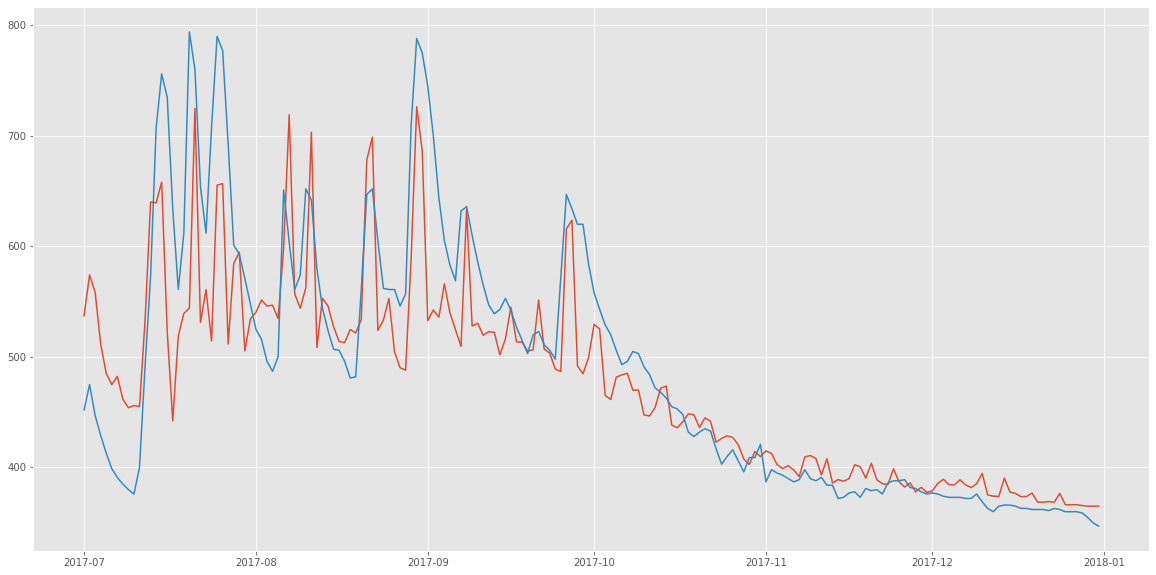

In [701]:
res = pd.DataFrame(y_test.copy())
res['predicted'] = predict
plot_series(res['2017-07-01': ], cols = ['predicted', 'stage_max'])

In [487]:
# def step_forecast(model, var_prefix, x, n, d):
#     x_ = x.copy()
#     predictions = []
#     for i in range(n):
#         prediction = model.predict(x_)
#         predictions.append(prediction)
#         if i != n - 1:
#             for k in range(2, d + 1, -1):
#                 x_[var_prefix + str(k)] = x_[var_prefix + str(k - 1)] 
#             x_[var_prefix + '10'] = prediction
#     return np.stack(predictions, axis=0)

In [488]:
# forecast = step_forecast(model, 'stage_max_t_', X_test, 10, 20)

In [702]:
import shap
X_importance = X_train
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

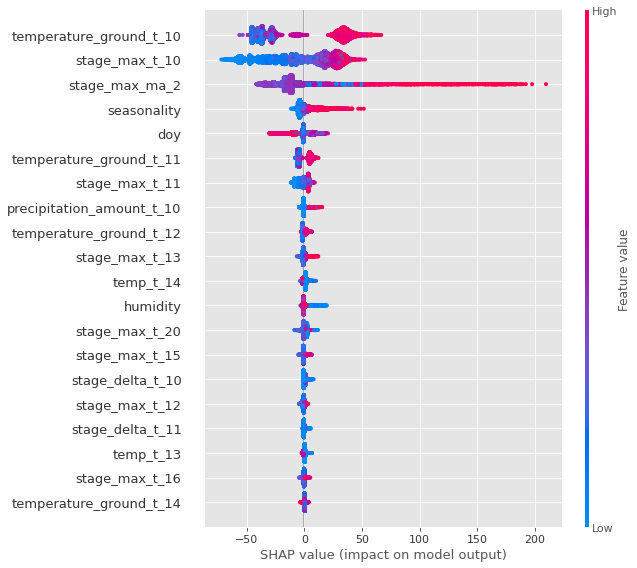

In [703]:
shap.summary_plot(shap_values, X_importance)